## Training Model

### how can we predict multiple swell heights and directions? 

- each time stamp (every 30 minutes) has the dominant swell height. We want to predict this
- for a 1 day prediction. get all the data as late as one day ago, and this is a data point with many dimensions. Maybe grab a snapshot of each buoy from 
- encode this into a large vector. Use WvHT (waveheight), MWD (main swell direction in degrees), ans SwP as prediction. 
- put this in a neural network because this will be non linear and high dimensional

In [1]:
import torch
import pandas as pd
import sqlite3
import numpy as np
import functions

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from matplotlib import pyplot as plt

In [2]:
conn = sqlite3.connect('db.db')
data = pd.read_sql_query("SELECT * from main", conn)
data = functions.buildnparray(functions.cleanData(data))

(1346, 76, 3)


### parameters

In [10]:
sequence_length = 24 * 10  # length of sequence, 24 hours * 10 days
batch_size = 32      # Batch size for training
num_epochs = 70      # Number of training epochs

In [4]:
data_tensor = torch.Tensor(data) # convert to pytorch tensor

data_tensor = torch.reshape(data_tensor, (-1, 3))
nan_mask = torch.isnan(data_tensor)
data_tensor[nan_mask] = 0

In [5]:
# Create input sequences and corresponding target values
input_sequences = []
target_values = []

for i in range(len(data) - sequence_length):
    input_seq = data_tensor[i:i+sequence_length]  
    target_val = data_tensor[i+sequence_length] 
    input_sequences.append(input_seq)
    target_values.append(target_val)
# print("input sequences", input_sequences.shape)

input_sequences = torch.stack(input_sequences)
target_values = torch.stack(target_values)

dataset = TensorDataset(input_sequences, target_values)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [6]:
class WaveForecastingRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(WaveForecastingRNN, self).__init__()
        # self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) # recurrent neural network
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True) # long short term memory model
        self.fc = nn.Linear(hidden_size, output_size) # fully connected layer

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Use the last time step's output for prediction
        return out

In [36]:
loss_errors = []

In [37]:
num_features = 3
input_size = num_features
hidden_size = 64
num_layers = 1 
output_size = num_features

model = WaveForecastingRNN(input_size, hidden_size, num_layers, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(num_epochs):
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss_errors.append(loss.item())
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

torch.save(model.state_dict(), 'model_weights.pth')


Epoch [1/70], Loss: 22316.3516
Epoch [2/70], Loss: 15855.3232
Epoch [3/70], Loss: 18788.8164
Epoch [4/70], Loss: 22861.9199
Epoch [5/70], Loss: 18062.7207
Epoch [6/70], Loss: 15652.2852
Epoch [7/70], Loss: 8621.2461
Epoch [8/70], Loss: 12161.7549
Epoch [9/70], Loss: 15417.0977
Epoch [10/70], Loss: 13290.4375
Epoch [11/70], Loss: 15782.1562
Epoch [12/70], Loss: 12963.9834
Epoch [13/70], Loss: 10802.8799
Epoch [14/70], Loss: 14929.9893
Epoch [15/70], Loss: 18010.0957
Epoch [16/70], Loss: 15281.8838
Epoch [17/70], Loss: 11761.3574
Epoch [18/70], Loss: 15351.1270
Epoch [19/70], Loss: 13076.4102
Epoch [20/70], Loss: 10261.7334
Epoch [21/70], Loss: 10802.5186
Epoch [22/70], Loss: 14226.4414
Epoch [23/70], Loss: 14856.4668
Epoch [24/70], Loss: 12138.3975
Epoch [25/70], Loss: 9857.8682
Epoch [26/70], Loss: 9402.1826
Epoch [27/70], Loss: 7959.6182
Epoch [28/70], Loss: 10125.8555
Epoch [29/70], Loss: 11030.7051
Epoch [30/70], Loss: 9110.7451
Epoch [31/70], Loss: 10528.9004
Epoch [32/70], Loss: 7

In [38]:
iterations = range(1, len(loss_errors) + 1)

In [41]:
# loss_errors = list(map(lambda x: x.detach().numpy(), loss_errors))
# loss_errors = loss_errors.detach().numpy()

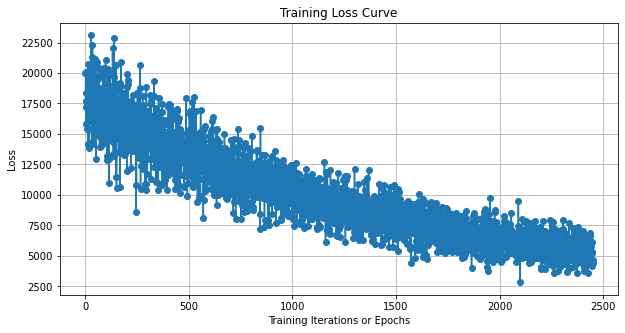

In [42]:
plt.figure(figsize=(10, 5))
plt.plot(iterations, loss_errors, marker='o', linestyle='-')
plt.title('Training Loss Curve')
plt.xlabel('Training Iterations or Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()